# Customer CLTV Prediction

## What is BG/NGD & Gamma-Gamma Model 
- The `BG/NBD (Beta Geometric/Negative Binomial Distribution)` and `Gamma-Gamma models` are part of customer lifetime value (CLV) analysis, often used for `predicting the likelihood of a customer returning and their expected monetary value`. 
- These models are different from typical classification models, as they focus on predicting `frequency, recency, and monetary` value rather than binary outcomes.

# Table of Content

1. [Data Understanding](#1)
2. [Data Preparation](#2)
3. [EDA](#3)
4. [BG/NGD & Gamma-Gamma Model](#4)
5. [Segmentation](#5)

# Import Library

In [6]:
# !pip install lifetimes

In [7]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
import datetime as dt 

# BG/NBD & Gamma-Gamma Model 
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.plotting import plot_frequency_recency_matrix, plot_probability_alive_matrix
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes.plotting import plot_period_transactions

# 1. Data Understanding <a name="1"></a>

**customer.csv**
1. `order_id` : Order number
2. `customer_id` : customer_number
3. `payment_value` : Total price paid by the customer
   
**order.csv**
1. `order_purchase_timestamp` : Date of customer purchase
2. `order_id` : Order number

# 2. Data Preparation <a name="2"></a>

In [11]:
# Load dataset
customer = pd.read_csv("customer.csv") 
order = pd.read_csv("order.csv") 

In [12]:
# Dimension of customer 
print(f'Number of rows: {customer.shape[0]}')
print(f'Number of columns: {customer.shape[1]}')
print('-'*50)

# Dimension of order 
print(f'Number of rows: {order.shape[0]}')
print(f'Number of columns: {order.shape[1]}')

Number of rows: 117601
Number of columns: 3
--------------------------------------------------
Number of rows: 99441
Number of columns: 2


In [13]:
# Merge dataset  
data = pd.merge(customer, order, on='order_id')

In [14]:
# Dimension of data 
print(f'Number of rows: {data.shape[0]}')
print(f'Number of columns: {data.shape[1]}')

Number of rows: 117601
Number of columns: 4


In [15]:
# Export the dataset (if required) 
# data.to_csv("data.csv", index=False)

In [16]:
data.head()

,order_id,customer_id,payment_value,order_purchase_timestamp
0,00010242fe8c5a6d1ba2dd792cb16214,48436dade18ac8b2bce089ec2a041202,72.19,2017-09-13 08:59:02
1,00018f77f2f0320c557190d7a144bdd3,dd7ddc04e1b6c2c614352b383efe2d36,259.83,2017-04-26 10:53:06
2,000229ec398224ef6ca0657da4fc703e,5b51032eddd242adc84c38acab88f23d,216.87,2018-01-14 14:33:31
3,00024acbcdf0a6daa1e931b038114c75,9d7a1d34a5052409006425275ba1c2b4,25.78,2018-08-08 10:00:35
4,00042b26cf59d7ce69dfabb4e55b4fd9,df560393f3a51e74553ab94004ba5c87,218.04,2017-02-04 13:57:51


In [17]:
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117601 entries, 0 to 117600
Data columns (total 4 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   order_id                  117601 non-null  object 
 1   customer_id               117601 non-null  object 
 2   payment_value             117601 non-null  float64
 3   order_purchase_timestamp  117601 non-null  object 
dtypes: float64(1), object(3)
memory usage: 3.6+ MB


In [18]:
# Convert the order_purchase_timestam to datetime format 
data['order_purchase_timestamp'] = pd.to_datetime(data['order_purchase_timestamp'])

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117601 entries, 0 to 117600
Data columns (total 4 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   order_id                  117601 non-null  object        
 1   customer_id               117601 non-null  object        
 2   payment_value             117601 non-null  float64       
 3   order_purchase_timestamp  117601 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 3.6+ MB


In [20]:
# Check for null value 
print(f"Null Value Rows:\n{data.isnull().sum()}")
print('-' * 50)

# Check for duplicate value 
print(f"Duplicated Rows: {data.duplicated().sum()}")

Null Value Rows:
order_id                    0
customer_id                 0
payment_value               0
order_purchase_timestamp    0
dtype: int64
--------------------------------------------------
Duplicated Rows: 13720


In [21]:
# Filter duplicate rows 
data_filtered = data.drop_duplicates()

# Keep only duplicate rows
data_duplicate = data[data.duplicated(keep=False)]

In [22]:
# Dimension of data_filtered 
print(f'Number of rows: {data_filtered.shape[0]}')
print(f'Number of columns: {data_filtered.shape[1]}')
print('-'*50)

# Dimension of data_duplicate 
print(f'Number of rows: {data_duplicate.shape[0]}')
print(f'Number of columns: {data_duplicate.shape[1]}')

Number of rows: 103881
Number of columns: 4
--------------------------------------------------
Number of rows: 23191
Number of columns: 4


# 3. EDA <a name="3"></a>

## Total payment value and orders by date

In [25]:
print('Total payment value & orders by date')
eda1 = data_filtered.groupby(data_filtered['order_purchase_timestamp'].dt.date).agg({'payment_value': 'sum', 'order_id': 'count'})
eda1

Total payment value & orders by date


,payment_value,order_id
order_purchase_timestamp,,
2016-09-04,136.23,1
2016-09-05,75.06,1
2016-10-02,109.34,1
2016-10-03,595.14,8
2016-10-04,11295.48,67
...,...,...
2018-08-26,9495.94,78
2018-08-27,6292.59,69
2018-08-28,4240.66,41


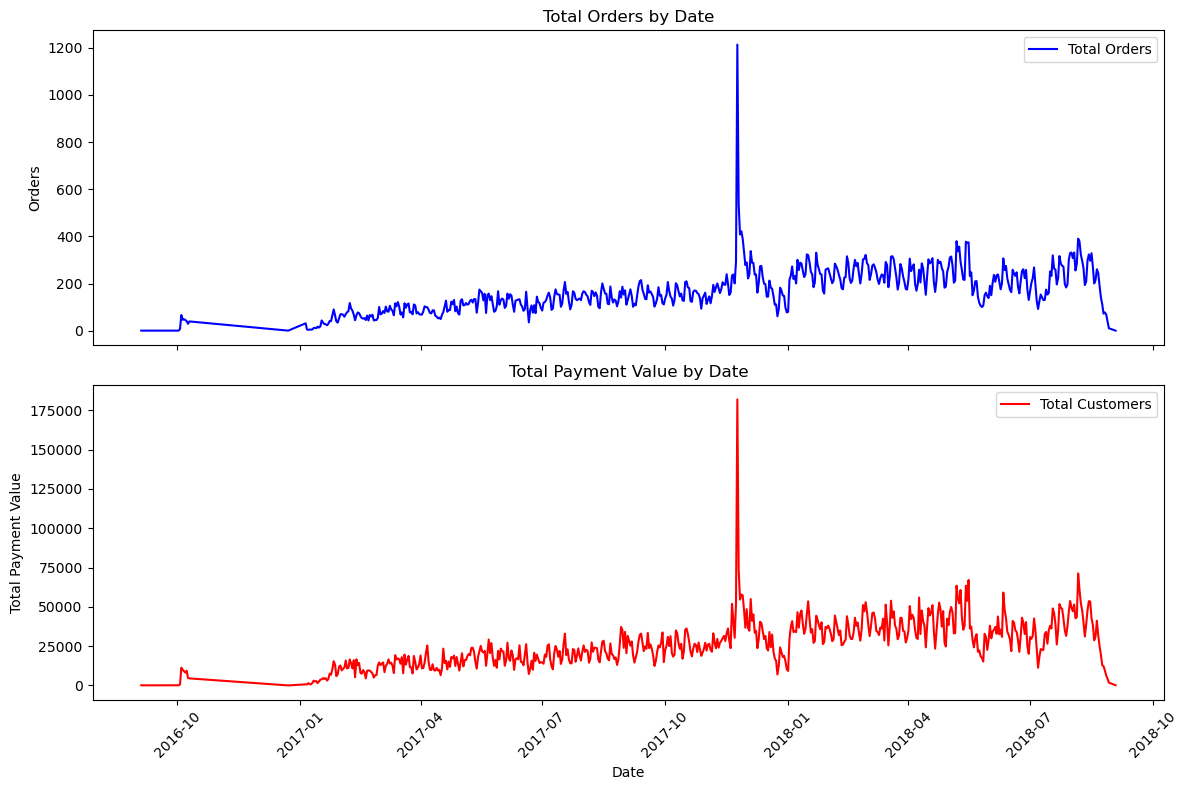

In [26]:
# Line Chart for total order & payment value by date
# Sort dates and plot the customer data
sorted_dates = sorted(data_filtered['order_purchase_timestamp'].dt.date.unique())

# Create a figure with subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot Total Orders
axes[0].plot(sorted_dates, eda1['order_id'], label='Total Orders', color='blue')
axes[0].set_title('Total Orders by Date')
axes[0].set_ylabel('Orders')
axes[0].legend()

# Plot Total Customers
axes[1].plot(sorted_dates, eda1['payment_value'], label='Total Customers', color='red')
axes[1].set_title('Total Payment Value by Date')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Total Payment Value')
axes[1].legend()

# Format x-axis
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [27]:
eda1.describe()

,payment_value,order_id
count,615.000000,615.000000
mean,26313.408813,168.912195
std,15063.027802,95.176155
min,19.620000,1.000000
25%,15658.695000,104.000000
50%,24223.870000,158.000000
75%,35098.170000,227.000000
max,181877.460000,1213.000000


In [28]:
# Top 10 payment value and orders 
eda1.sort_values('payment_value', ascending=False).head(10)

,payment_value,order_id
order_purchase_timestamp,,
2017-11-24,181877.46,1213
2017-11-25,73497.09,536
2018-08-06,71210.19,391
2018-05-16,67062.55,375
2018-05-07,63428.19,380
2018-05-14,63411.83,378
2018-08-07,60984.37,379
2018-05-10,60629.95,293
2018-06-11,59064.18,307


In [29]:
# Last 10 payment value and orders 
eda1.sort_values('payment_value', ascending=False).tail(10)

,payment_value,order_id
order_purchase_timestamp,,
2017-01-08,809.63,6
2017-01-09,774.51,5
2017-01-05,707.27,32
2016-10-03,595.14,8
2017-01-06,588.28,6
2018-09-03,166.46,1
2016-09-04,136.23,1
2016-10-02,109.34,1
2016-09-05,75.06,1


## Total payment value and orders by duration

In [31]:
# Create new column duration 
def get_duration(hour):
    if 5 <= hour <= 12:
        return "Morning"
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

data_filtered['duration'] = data_filtered['order_purchase_timestamp'].dt.hour.apply(get_duration)

In [32]:
data_filtered.head()

,order_id,customer_id,payment_value,order_purchase_timestamp,duration
0,00010242fe8c5a6d1ba2dd792cb16214,48436dade18ac8b2bce089ec2a041202,72.19,2017-09-13 08:59:02,Morning
1,00018f77f2f0320c557190d7a144bdd3,dd7ddc04e1b6c2c614352b383efe2d36,259.83,2017-04-26 10:53:06,Morning
2,000229ec398224ef6ca0657da4fc703e,5b51032eddd242adc84c38acab88f23d,216.87,2018-01-14 14:33:31,Afternoon
3,00024acbcdf0a6daa1e931b038114c75,9d7a1d34a5052409006425275ba1c2b4,25.78,2018-08-08 10:00:35,Morning
4,00042b26cf59d7ce69dfabb4e55b4fd9,df560393f3a51e74553ab94004ba5c87,218.04,2017-02-04 13:57:51,Afternoon


In [33]:
print('Total payment value & orders by duration')
eda2 = data_filtered.groupby(data_filtered['duration']).agg({'payment_value': 'sum', 'order_id': 'count'})
# Format the values
eda2[['payment_value', 'order_id']] = eda2[['payment_value', 'order_id']].applymap(
    lambda x: f"{x:,.2f}" if isinstance(x, float) else f"{x:,}"
)
eda2

Total payment value & orders by duration


,payment_value,order_id
duration,,
Afternoon,"4,358,128.87","27,327"
Evening,"3,967,545.92","25,165"
Morning,"4,599,552.93","29,596"
Night,"3,257,518.70","21,793"


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


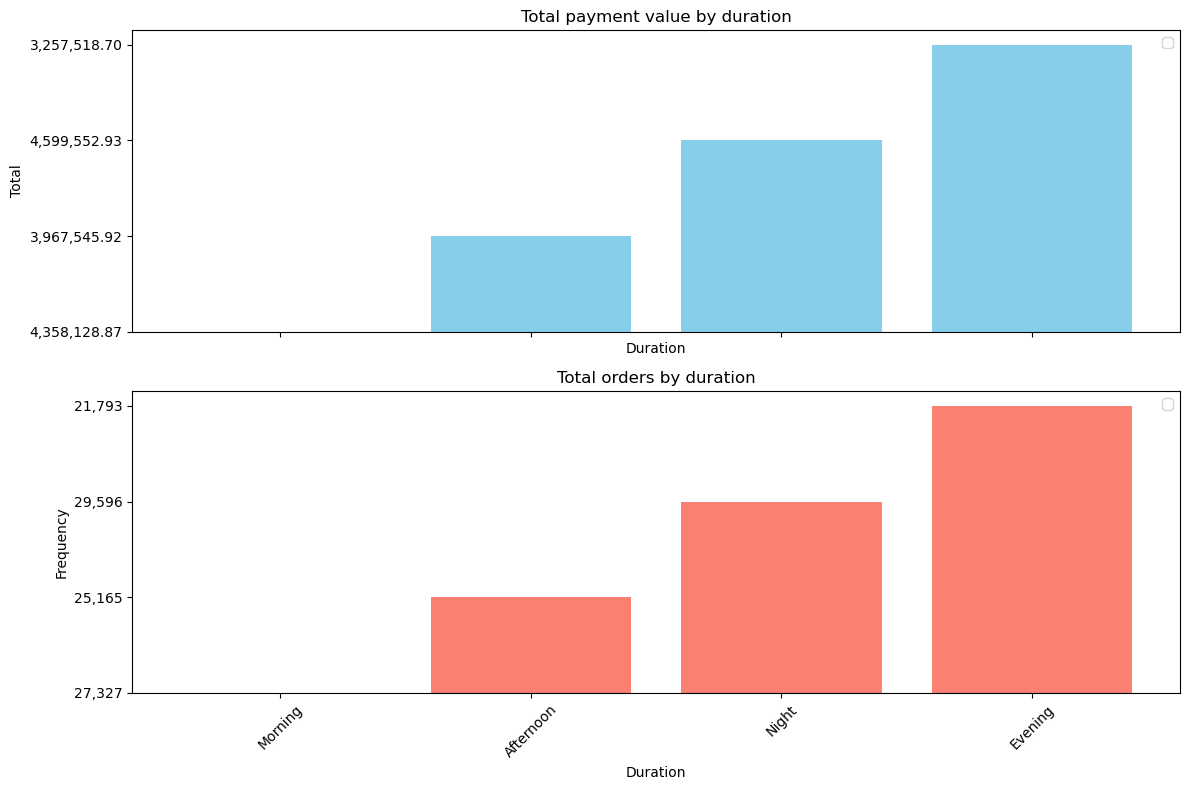

In [34]:
# Bar chart: Total payment value and orders by duration 
fig, axes = plt.subplots(2, 1, figsize=(12,8), sharex=True)

# Bar plot for total payment value
axes[0].bar(data_filtered['duration'].unique(), eda2['payment_value'], color='skyblue')
axes[0].set_title("Total payment value by duration")
axes[0].set_ylabel("Total")
axes[0].set_xlabel("Duration") 
axes[0].legend()

# Bar plot for total orders 
axes[1].bar(data_filtered['duration'].unique(), eda2['order_id'], color='salmon')
axes[1].set_title("Total orders by duration")
axes[1].set_ylabel("Frequency")
axes[1].set_xlabel("Duration") 
axes[1].legend()

# Format x-axis
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4. BG/NBD & Gamma-Gamma Model <a name="4"></a>

In [36]:
# Aggregate data to transaction level
summary = summary_data_from_transaction_data(
    data_filtered,
    customer_id_col='customer_id',
    datetime_col='order_purchase_timestamp',
    monetary_value_col='payment_value',
    observation_period_end=data_filtered['order_purchase_timestamp'].max()  # Use the last date as the end of the observation period
)

In [37]:
summary.head()

,frequency,recency,T,monetary_value
customer_id,,,,
0015a82c2db000af6aaaf3ae2ecb0532,2.0,22.0,342.0,916.020000
001cca7ae9ae17fb1caed9dfb1094831,152.0,523.0,576.0,223.020329
001e6ad469a905060d959994f1b41e4f,0.0,0.0,27.0,0.000000
002100f778ceb8431b7a1020ff7ab48f,41.0,210.0,354.0,53.113171
003554e2dce176b5555353e4f3555ac8,0.0,0.0,262.0,0.000000


In [38]:
# Filter out non-positive monetary values
summary = summary[summary['monetary_value'] > 0]

In [39]:
summary.shape

(2516, 4)

In [40]:
# Ensure 'monetary_value' is the average payment value
monetary_value = data_filtered.groupby('customer_id')['payment_value'].mean().reset_index(name='monetary_value')

# Filter out non-positive monetary values
monetary_value = monetary_value[monetary_value['monetary_value'] > 0]

In [41]:
# Check for any remaining non-positive values in the monetary_value column
print(summary[summary['monetary_value'] <= 0])

Empty DataFrame
Columns: [frequency, recency, T, monetary_value]
Index: []


                                  frequency  recency      T  monetary_value  \
customer_id                                                                   
6560211a19b47992c3666cc44a7e94c0      505.0    558.0  563.0      303.797980   
4a3ca9315b744ce9f8e9374361493884      536.0    596.0  603.0      463.471007   
955fee9216a65b617aa5c0531780ce60      324.0    400.0  406.0      499.312562   
cc419e0650a3c5ba77189a1882b7556a      482.0    573.0  580.0      272.572967   
da8622b14eb17ae2831f4ac5b9dab84a      437.0    569.0  575.0      435.065286   
3d871de0142ce09b7081e2b9d1733cb1      402.0    539.0  547.0      296.082015   
c70c1b0d8ca86052f45a432a38b73958      104.0    145.0  150.0      389.891058   
e9779976487b77c6d4ac45f75ec7afe9      350.0    545.0  551.0      155.770200   
1025f0e2d44d7041d6cf58b6550e0bfa      307.0    413.0  421.0      577.891564   
9f505651f4a6abe901a56cdc21508025      209.0    328.0  333.0      155.659091   

                                  expected_4_weeks 

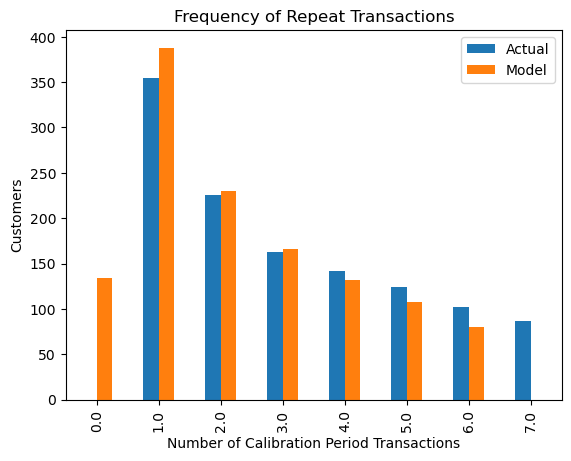

                                  frequency  recency      T  monetary_value  \
customer_id                                                                   
0015a82c2db000af6aaaf3ae2ecb0532        2.0     22.0  342.0      916.020000   
001cca7ae9ae17fb1caed9dfb1094831      152.0    523.0  576.0      223.020329   
002100f778ceb8431b7a1020ff7ab48f       41.0    210.0  354.0       53.113171   
004c9cd9d87a3c30c522c48c4fc07416      125.0    461.0  584.0      182.060400   
00720abe85ba0859807595bbf045a33b       12.0    188.0  219.0       98.817500   

                                  expected_4_weeks           CLV  
customer_id                                                       
0015a82c2db000af6aaaf3ae2ecb0532      3.316812e-04  1.368455e+01  
001cca7ae9ae17fb1caed9dfb1094831      4.558690e-04  4.320011e+00  
002100f778ceb8431b7a1020ff7ab48f      7.147865e-08  1.599463e-04  
004c9cd9d87a3c30c522c48c4fc07416      1.226709e-10  9.494920e-07  
00720abe85ba0859807595bbf045a33b      2.0728

C:\Users\lic02\anaconda3\Lib\site-packages\lifetimes\fitters\beta_geo_fitter.py:256: RuntimeWarning: overflow encountered in scalar power
  denominator = 1 + (x > 0) * (a / (b + x - 1)) * ((alpha + T) / (alpha + recency)) ** (r + x)


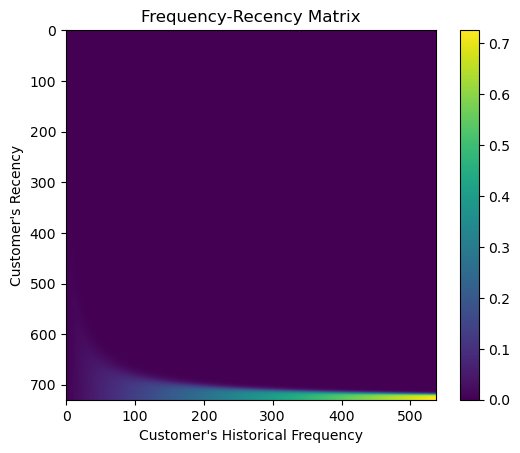

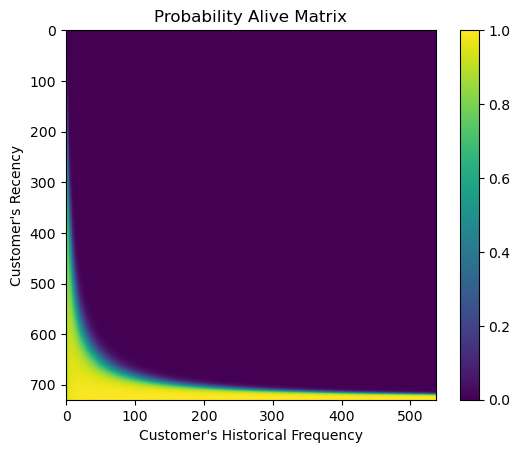

In [42]:
# BG/NBD model (frequency and recency)
bgf = BetaGeoFitter(penalizer_coef=0.01)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])

# Predict the number of transactions for each customer over the next 4 weeks.
summary["expected_4_weeks"] = bgf.predict(4,
                                          summary['frequency'],
                                          summary['recency'],
                                          summary['T'])
print(summary.sort_values(by="expected_4_weeks", ascending=False).head(10))
# Customer 656021xxx is predicted to make approximately 3 transactions in the next 4 weeks.

# Evaluate BN/NBD model 
plot_period_transactions(bgf)
plt.show(block=True)

# Gamma-Gamma model (monetary value)
ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(summary['frequency'], summary['monetary_value'])

# Predict Customer Lifetime Value (CLV) over the next 6 months
summary['CLV'] = ggf.customer_lifetime_value(
    bgf,
    summary['frequency'],
    summary['recency'],
    summary['T'],
    summary['monetary_value'],
    time=6,  # Predicting for the next 6 months
    discount_rate=0.01  # Annual discount rate
)

# Visualize key metrics
print(summary.head())

# Plot frequency/recency matrix
plot_frequency_recency_matrix(bgf)
plt.title('Frequency-Recency Matrix')
plt.show()

# Plot probability alive matrix
plot_probability_alive_matrix(bgf)
plt.title('Probability Alive Matrix')
plt.show()

## Explanation

### 1. CLV (Customer Lifetime Value):
The table shows the calculated Customer Lifetime Value (CLV) for each customer, which is an estimate of the total revenue that each customer will bring over the `next 6 months`, `discounted at 1%(0.01)` annually. Here's how to interpret the columns:
1. `frequency` : Number of repeat transactions minus one for each customer. For example, the first customer made 2 purchases, and the second customer made 152 purchases.
2. `recency`: The number of days since the last purchase. For the first customer, it's been 22 days since their last purchase, whereas for the second customer, it's 523 days.
3. `T`: The tenure, which is the number of days since the customer's first purchase. For the first customer, this is 342 days, and for the second customer, it's 576 days.
4. `monetary_value`: The average amount spent by the customer per transaction. For example, the first customer spent an average of 916.02, while the second customer spent 223.02.
5. `CLV`: This column shows the predicted customer lifetime value, which takes into account the frequency, recency, tenure, and monetary value.

### 2. Frequency-Recency Matrix:
The Frequency-Recency Matrix shows the relationship between a customer's frequency of transactions and their recency (the time since their last purchase). Here's how to interpret the plot:
1. The x-axis represents the customer's historical frequency (number of purchases made).
2. The y-axis represents the recency (the time since the last purchase).
3. The color intensity represents the proportion of customers with that particular frequency and recency combination. A dark purple color indicates a low number of customers, while green and yellow areas represent more customers.
 
In the matrix, you see that `most customers seem to have lower frequencies (under 100 purchases)` and a `relatively higher recency`. This suggests that `many customers have made fewer purchases` and `haven't been active recently`.

### 3. Probability Alive Matrix:
The Probability Alive Matrix is used to visualize the likelihood that a customer is still alive (i.e., will make another purchase). It is a function of frequency and recency. Here's the interpretation:
1. The x-axis represents the frequency (number of transactions).
2. The y-axis represents recency (days since the last purchase).
3. The color intensity represents the probability that the customer is still "alive" or has a chance to make another purchase. A higher probability is indicated by yellow or green, while lower probabilities are indicated by blue and purple.
 
In this case, it looks like customers with `high recency (many days since their last purchase)` and `low frequency (fewer purchases)` tend to have a `lower probability of being alive (making future purchases)`. In contrast, `customers with moderate recency and frequency` have a `higher likelihood of returning`.

### Summary:
1. `High CLV`: Customers with high frequency, recent activity, and high monetary value contribute more to the company's revenue in the future.
2. `Frequency-Recency & Probability Alive`: The plots indicate that customers with high recency (long time since the last purchase) and low frequency (few purchases) are less likely to make future purchases, which is a typical observation for churn-prone customers.
3. `Customer Retention`: The Probability Alive Matrix can help you target customers who are still likely to make purchases by focusing on those with moderate frequency and recency.

# 5. Segmentation <a name="5"></a>

## Segmentation Based on CLV 
Segment customers based on their CLV (Customer Lifetime Value) prediction. Customers with a higher CLV will be considered more valuable, and you can focus retention efforts on high CLV customers.
 
**Possible Segments:**
1. `Low CLV`: Customers with low future revenue potential.
2. `Premium CLV`: Customers with very high future revenue potential.

In [50]:
# Method 1: Segment customers based on CLV
summary['CLV_segment'] = pd.cut(summary['CLV'], bins=[0, 50, 200, 500, 1000, float('inf')], labels=['Low', 'Medium', 'High', 'Very High', 'Premium'])

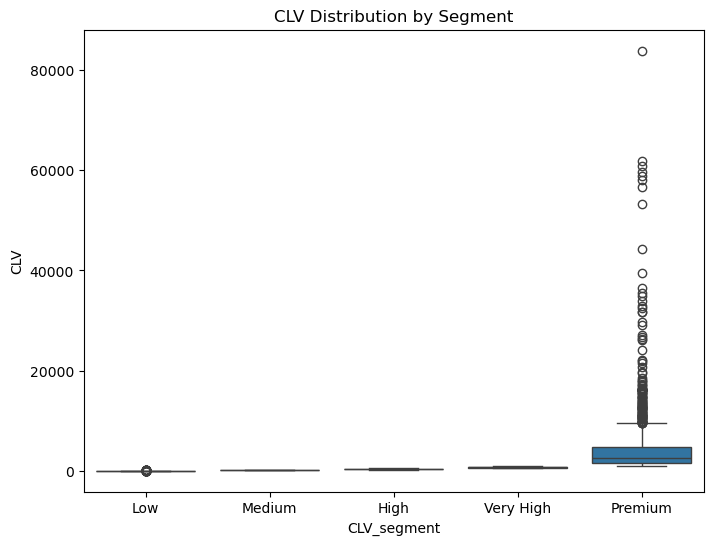

In [51]:
# Visualize the distribution of CLV by segment
plt.figure(figsize=(8, 6))
sns.boxplot(x='CLV_segment', y='CLV', data=summary)
plt.title('CLV Distribution by Segment')
plt.show()

In [52]:
# Method 2: Segment into 4 groups
summary['CLV_segment2'] = pd.qcut(summary["CLV"], 4, labels=["D", "C", "B", "A"])

In [53]:
summary.columns

Index(['frequency', 'recency', 'T', 'monetary_value', 'expected_4_weeks',
       'CLV', 'CLV_segment', 'CLV_segment2'],
      dtype='object')

In [54]:
col = ['frequency', 'recency', 'T', 'monetary_value', 'expected_4_weeks', 'CLV']
summary.groupby('CLV_segment2')[col].agg({"count", "mean", "sum"})

frequency                    recency                           T  \
                   sum count       mean       sum count        mean       sum   
CLV_segment2                                                                    
D              10853.0   629  17.254372   88721.0   629  141.050874  287009.0   
C               4238.0   629   6.737679  116054.0   629  184.505564  179994.0   
B              10444.0   629  16.604134  145789.0   629  231.779014  166602.0   
A              40782.0   629  64.836248  194907.0   629  309.868045  206591.0   

                               monetary_value                    \
             count        mean            sum count        mean   
CLV_segment2                                                      
D              629  456.294118  121704.947762   629  193.489583   
C              629  286.158983  114393.906114   629  181.866305   
B              629  264.868045  131100.514928   629  208.426892   
A              629  328.443561  230323.343782   629  366.173837   

             expected_4_weeks                           CLV                     
                          sum count      mean           sum count         mean  
CLV_segment2                                                                    
D                    1.053069   629  0.001674  4.731383e+03   629     7.522072  
C                   39.981684   629  0.063564  1.633187e+05   629   259.648182  
B                  129.602799   629  0.206046  7.414034e+05   629  1178.701696  
A                  389.335180   629  0.618975  4.302314e+06   629  6839.926750